#  TF.data 활용하여 쉽게 Epoch , minibatch 구현하기 
## 좀 더 큰 데이터에 다룰 때 feed_dict  보다 적합한 기술이라고 함.
## 그리고 되기만 하면 좀 더 간단...


## [ Stochastic Wegiht Averaging Url ](https://github.com/JGuillaumin/swa-tf/blob/master/step_by_step_swa.ipynb)

## [직관적인 설명](https://towardsdatascience.com/stochastic-weight-averaging-a-new-way-to-get-state-of-the-art-results-in-deep-learning-c639ccf36a)

* 많이 각색? 해버리긴 했지만 돌아는 간다....



In [2]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis
slim = tf.contrib.slim
from pprint import pprint
from tensorflow.contrib.distributions import percentile as tf_percent

# from tensorflow.python.client import device_lib 
# #print(device_lib.list_local_devices())
# print(tf.test.is_gpu_available())

import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
    
    
device = ['/gpu:1' , '/gpu:0']       

import pprint
pp = pprint.PrettyPrinter(width=20, indent=4)



from moving_free_batch_normalization import moving_free_batch_norm
from stochastic_weight_averaging import StochasticWeightAveraging

GPU found


In [3]:


data = pd.read_csv("./credit44_sc.csv" )

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def log(x):
    return tf.log(x + 1e-8)


def spectral_norm(w, iteration=1 , name = None):
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])
    
    u = tf.get_variable(name , [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

    u_hat = u
    v_hat = None
    for i in range(iteration):
       
        """
       power iteration
       Usually iteration = 1 will be enough
       """
        
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = tf.nn.l2_normalize(v_)

        u_ = tf.matmul(v_hat, w)
        u_hat = tf.nn.l2_normalize(u_)

    u_hat = tf.stop_gradient(u_hat)
    v_hat = tf.stop_gradient(v_hat)

    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = w / sigma
        w_norm = tf.reshape(w_norm, w_shape)

    return w_norm 

In [5]:
# tf.reset_default_graph()
# X = tf.placeholder(tf.float32, shape=[None, X_dim], name="X")
# D_W1 = tf.get_variable("DW1",[X_dim, h_dim], dtype=tf.float32)
# # spectral_norm(D_W1)
# D_b1 = tf.get_variable("DB1", [h_dim], dtype=tf.float32 , initializer=tf.constant_initializer(0.0))
# tf.nn.relu(tf.matmul(X, spectral_norm(D_W1)) + D_b1)

# tf.reset_default_graph()
# kernel , channels = 5, 3 
# x =X 
# stride =2 
# w = tf.get_variable("kernel", shape=[kernel, kernel, x.get_shape()[-1], channels])
# b = tf.get_variable("bias", [channels], initializer=tf.constant_initializer(0.0))

# x = tf.nn.conv2d(input=x, filter=spectral_norm(w), strides=[1, stride, stride, 1],padding ="SAME") + b

#D_h1 = tf.nn.relu(tf.matmul(X, spectral_norm(D_W1)) + D_b1)

# =====================
# Tuning Path , Hidden , etc
# =====================

In [6]:
mb_size = 1000
X_dim = np.shape(data)[1]
z_dim = 64
h_dim = 128
lr = 1e-4
d_steps = 5
EPOCHS = 50000

data_len = np.shape(data)[0]
batch_iter = int(data_len / mb_size)

print("Batch Iteration : ", batch_iter)

title = "RSGAN_TF.data_SWA"

path_v = "RSGAN_TF_Data_SWA"

model_dir = "./Model_Save/{}".format(path_v)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


Batch Iteration :  9


mb_size = 32
X_dim = np.shape(data)[1]
z_dim = 64
h_dim = 128
lr = 1e-3
d_steps = 3

나쁘지 않게 나온다.

In [7]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, X_dim], name="X")
Z = tf.placeholder(tf.float32, shape=[None, z_dim], name="z")
batch_size = tf.placeholder(tf.int64)
dataset = tf.data.Dataset.from_tensor_slices((X, Z)).batch(batch_size).repeat().shuffle(1000)

iter = dataset.make_initializable_iterator()
x , z = iter.get_next()

is_training_bn = tf.placeholder(shape=[], dtype=tf.bool)
use_moving_statistics = tf.placeholder(shape=[], dtype=tf.bool)
learning_rate = tf.placeholder(shape=[], dtype=tf.float32)

def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])



def D(X,reuse=tf.AUTO_REUSE ):
    with tf.device(device[0]) :
        with tf.variable_scope( "Discriminator" ,reuse=reuse  ) as scope :
            D_W1 = tf.get_variable("DW1",[X_dim, h_dim], dtype=tf.float32)
            D_b1 = tf.get_variable("DB1", [h_dim], dtype=tf.float32 , initializer=tf.constant_initializer(0.0))
            D_W2 = tf.get_variable("DW2",[h_dim, h_dim], dtype=tf.float32)
            D_b2 = tf.get_variable("DB2",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            D_W3 = tf.get_variable("DW3",[h_dim, h_dim], dtype=tf.float32)
            D_b3 = tf.get_variable("DB3",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            D_W4 = tf.get_variable("DW4",[h_dim, 1], dtype=tf.float32)
            D_b4 = tf.get_variable("DB4",[1], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            
            
            D_h1 = tf.nn.leaky_relu(tf.matmul(X, spectral_norm(D_W1 , name ="sn1")) + D_b1)
            D_h2 = tf.nn.leaky_relu(tf.matmul(D_h1, spectral_norm(D_W2 , name ="sn2")) + D_b2)
            D_h3 = tf.nn.leaky_relu(tf.matmul(D_h2, spectral_norm(D_W3 , name ="sn3")) + D_b3)
            out = tf.matmul(D_h3 , D_W4) # + D_b4
        return out


def G( Z = None , reuse = tf.AUTO_REUSE) : 
    with tf.device(device[1]) :
        with tf.variable_scope("Generator" , reuse = reuse) as scope: 
            G_W1 = tf.get_variable("GW1",[z_dim, h_dim], dtype=tf.float32 , initializer=tf.contrib.layers.xavier_initializer())
            G_b1 = tf.get_variable("GB1",[h_dim],dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W2 = tf.get_variable("GW2" ,[h_dim, h_dim], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
            G_b2 = tf.get_variable("GB2",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W3 = tf.get_variable("GW3" ,[h_dim, h_dim], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
            G_b3 = tf.get_variable("GB3",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W4 = tf.get_variable("GW4" ,[h_dim, X_dim], dtype=tf.float32)
            G_b4 = tf.get_variable("GB4",[X_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            
            G_h1 = tf.matmul(Z, G_W1 ) + G_b1
            #G_h1 = tf.contrib.layers.batch_norm(G_h1)
            G_h1 = moving_free_batch_norm(G_h1, axis=-1, training=is_training_bn,
                                          use_moving_statistics=use_moving_statistics, momentum=0.99)
            #G_h1 = tf.layers.dropout(G_h1)
            G_h1 = tf.nn.leaky_relu(G_h1)
            G_h2 = tf.matmul(G_h1, G_W2 ) + G_b2
            G_h2 = moving_free_batch_norm(G_h2, axis=-1, training=is_training_bn,
                                          use_moving_statistics=use_moving_statistics, momentum=0.99)
            #G_h2 = tf.contrib.layers.batch_norm(G_h2)
            #G_h2 = tf.layers.dropout(G_h2)
            G_h2 = tf.nn.leaky_relu(G_h2)
            G_h3 = tf.matmul(G_h2, G_W3) + G_b3
            #G_h3 = tf.layers.dropout(G_h3)
            G_h3 = moving_free_batch_norm(G_h3, axis=-1, training=is_training_bn,
                                          use_moving_statistics=use_moving_statistics, momentum=0.99)
            #G_h3 = tf.contrib.layers.batch_norm(G_h3)
            G_h3 = tf.nn.leaky_relu(G_h3)
            
            G_log_prob = tf.matmul(G_h3, G_W4) # + G_b2 Bias는 일단 제외 
            G_log_prob = tf.nn.tanh(G_log_prob)
            
        return G_log_prob 


def pullaway_loss(embeddings):
    ## https://github.com/hwalsuklee/tensorflow-generative-model-collections/blob/master/EBGAN.py 
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    similarity = tf.matmul(
        normalized_embeddings, normalized_embeddings, transpose_b=True)
    batch_size = tf.cast(tf.shape(embeddings)[0], tf.float32)
    pt_loss = (tf.reduce_sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
    return pt_loss
    
    

In [8]:
G_sample = G(z)

D_real = D(x )
D_fake = D(G_sample )


#Z = tf.reduce_sum(tf.exp(-D_real)) + tf.reduce_sum(tf.exp(-D_fake))
# D_loss = -tf.reduce_mean(log(D_real) + log(1 - D_fake))
# G_loss = 0.5 * tf.reduce_mean((log(D_fake) - log(1 - D_fake))**2)



fake_logit = D_fake
real_logit = D_real

# D_loss = - (tf.reduce_mean(log(real_logit ) + log(1 - fake_logit )))
# G_loss = - tf.reduce_mean(log(fake_logit ))

epsilon = 1e-14
## Discriminator (LAYER)
## Generator ( TANH)
## RaSGAN [꽝]
# D_loss = - tf.reduce_mean(tf.log(tf.nn.sigmoid(real_logit - fake_logit) + epsilon))
# G_loss = - tf.reduce_mean(tf.log(tf.nn.sigmoid(fake_logit - real_logit) + epsilon))

### RaSGAN  []
avg_fake_logit = tf.reduce_mean(fake_logit)
avg_real_logit = tf.reduce_mean(real_logit)
D_r_tilde = tf.nn.sigmoid(real_logit - avg_fake_logit)
D_f_tilde = tf.nn.sigmoid(fake_logit - avg_real_logit)
D_loss = - tf.reduce_mean(tf.log(D_r_tilde + epsilon)) - tf.reduce_mean(tf.log(1 - D_f_tilde + epsilon))
G_loss = - tf.reduce_mean(tf.log(D_f_tilde + epsilon)) - tf.reduce_mean(tf.log(1 - D_r_tilde + epsilon))

## RaHingeGan []
# d_tiled_r = real_logit - tf.reduce_mean(fake_logit, 0)
# d_tiled_f = fake_logit - tf.reduce_mean(real_logit, 0)
# D_loss = tf.reduce_mean(tf.maximum(0., 1. - d_tiled_r)) + tf.reduce_mean(tf.maximum(0., 1. + d_tiled_f))
# G_loss = tf.reduce_mean(tf.maximum(0., 1. - d_tiled_f)) + tf.reduce_mean(tf.maximum(0., 1. + d_tiled_r))


## "RSGAN-GP" [Very Very Good!!]
# e = tf.random_uniform([mb_size, 1], 0, 1)
# x_hat = e * X + (1 - e) * G_sample
# grad = tf.gradients(D(x_hat, reuse=True), x_hat)[0]
# D_loss = - tf.reduce_mean( tf.log(tf.nn.sigmoid(real_logit - fake_logit) + epsilon) ) 
# D_loss += 10 * tf.reduce_mean(tf.square(tf.sqrt(tf.reduce_sum(tf.square(grad), reduction_indices=[1])) - 1))
# G_loss = - tf.reduce_mean( tf.log(tf.nn.sigmoid(fake_logit - real_logit) + epsilon) )

"""
Url : https://blog.csdn.net/Geoffrey_MT/article/details/81198504
"""

####################### 새로 배운 것 #########################################

t_vars = tf.trainable_variables()
pp.pprint(t_vars)
print("\n")
d_vars = [var for var in t_vars if 'Discriminator' in var.name]
g_vars = [var for var in t_vars if 'Generator' in var.name]


pp.pprint(g_vars)
print("\n")
pp.pprint(d_vars)

[   <tf.Variable 'Generator/GW1:0' shape=(64, 128) dtype=float32_ref>,
    <tf.Variable 'Generator/GB1:0' shape=(128,) dtype=float32_ref>,
    <tf.Variable 'Generator/GW2:0' shape=(128, 128) dtype=float32_ref>,
    <tf.Variable 'Generator/GB2:0' shape=(128,) dtype=float32_ref>,
    <tf.Variable 'Generator/GW3:0' shape=(128, 128) dtype=float32_ref>,
    <tf.Variable 'Generator/GB3:0' shape=(128,) dtype=float32_ref>,
    <tf.Variable 'Generator/GW4:0' shape=(128, 45) dtype=float32_ref>,
    <tf.Variable 'Generator/GB4:0' shape=(45,) dtype=float32_ref>,
    <tf.Variable 'Generator/moving_free_batch_normalization/gamma:0' shape=(128,) dtype=float32_ref>,
    <tf.Variable 'Generator/moving_free_batch_normalization/beta:0' shape=(128,) dtype=float32_ref>,
    <tf.Variable 'Generator/moving_free_batch_normalization_1/gamma:0' shape=(128,) dtype=float32_ref>,
    <tf.Variable 'Generator/moving_free_batch_normalization_1/beta:0' shape=(128,) dtype=float32_ref>,
    <tf.Variable 'Generator/movin

In [9]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
update_bn_ops = tf.get_collection('UPDATE_BN_OPS')
reset_bn_ops = tf.get_collection('RESET_BN_OPS')

## 존재 하지 않음 흐음... 

pp.pprint(update_ops)
pp.pprint(update_bn_ops)
pp.pprint(reset_bn_ops)

update_ops = tf.group(*update_ops)
update_bn_ops = tf.group(*update_bn_ops)
reset_bn_ops = tf.group(*reset_bn_ops)




[   <tf.Operation 'Generator/moving_free_batch_normalization/cond_2/Merge' type=Merge>,
    <tf.Operation 'Generator/moving_free_batch_normalization/cond_3/Merge' type=Merge>,
    <tf.Operation 'Generator/moving_free_batch_normalization_1/cond_2/Merge' type=Merge>,
    <tf.Operation 'Generator/moving_free_batch_normalization_1/cond_3/Merge' type=Merge>,
    <tf.Operation 'Generator/moving_free_batch_normalization_2/cond_2/Merge' type=Merge>,
    <tf.Operation 'Generator/moving_free_batch_normalization_2/cond_3/Merge' type=Merge>]
[   <tf.Tensor 'Generator/moving_free_batch_normalization/AssignAdd:0' shape=() dtype=float32_ref>,
    <tf.Tensor 'Generator/moving_free_batch_normalization_1/AssignAdd:0' shape=() dtype=float32_ref>,
    <tf.Tensor 'Generator/moving_free_batch_normalization_2/AssignAdd:0' shape=() dtype=float32_ref>]
[]


In [10]:
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    with tf.control_dependencies([update_ops,]):
        G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.0).minimize(G_loss, var_list=g_vars)
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.0).minimize(D_loss, var_list=d_vars)
    


In [11]:
with tf.name_scope('SWA'):
    swa = StochasticWeightAveraging()
    swa_op = swa.apply(var_list=g_vars)
    # Make backup variables
    with tf.variable_scope('BackupVariables'):
        backup_vars = [tf.get_variable(var.op.name, dtype=var.value().dtype, trainable=False,
                                       initializer=var.initialized_value())
                       for var in g_vars]
    # operation to assign SWA weights to model
    swa_to_weights = tf.group(*(tf.assign(var, swa.average(var).read_value()) for var in g_vars))
    # operation to store model into backup variables
    save_weight_backups = tf.group(*(tf.assign(bck, var.read_value()) for var, bck in zip(g_vars, backup_vars)))
    # operation to get back values from backup variables to model
    restore_weight_backups = tf.group(*(tf.assign(var, bck.read_value()) for var, bck in zip(g_vars, backup_vars)))

In [12]:
fac_var = []
num_var = []
for i in list(data) : 
    if data[i].nunique() < 15 : 
        print("factor variable : {}, count : {} ".format(i, data[i].nunique()))
        fac_var.append(i)
        if data[i].nunique() == 2 :
            print("binary" , i)
    else : 
        print("연속형 variable : {} , count : {} ".format(i, data[i].nunique()))
        num_var.append(i)
        
data = data.loc[:,fac_var + num_var]

col = list(data)

연속형 variable : SCORE_ORG , count : 395 
연속형 variable : SCORE_NK0200_000 , count : 445 
연속형 variable : SCORE_RK0400_700 , count : 294 
factor variable : CNT_CONTACT_POS, count : 8 
factor variable : CNT_ENG, count : 7 
factor variable : DAYS_CONTACT_POS, count : 11 
factor variable : DAYS_CALL_PAYMENT, count : 11 
factor variable : EWS_C_N_P27000100, count : 14 
연속형 variable : EWS_A_K_D1M232000_OPR , count : 2384 
factor variable : EWS_C_N_P42000200, count : 14 
연속형 variable : EWS_C_N_P32003000 , count : 31 
연속형 variable : AGE , count : 54 
연속형 variable : CNT_Contact , count : 29 
연속형 variable : EWS_A_K_D1M23200C_OPR , count : 2384 
연속형 variable : EWS_C_K_D10310000_OPR , count : 52 
연속형 variable : EWS_A_K_D90232200_OPR , count : 2490 
연속형 variable : D_N_CA0000603 , count : 4894 
연속형 variable : EWS_C_N_P32002600 , count : 22 
연속형 variable : EWS_D_N_P43004000 , count : 399 
factor variable : C_N_PS0001777, count : 11 
factor variable : A_K_D10220000_OPR, count : 9 
연속형 variable : SCORE_RK

In [13]:
from sklearn.preprocessing import MinMaxScaler

def sample_data(data = None , n= len(data)) : 
    output = data[list(np.random.choice(len(data) , n))]
    
    return output

scaler = MinMaxScaler(feature_range= (-1,1))

x_plot = pd.DataFrame(sample_data(data = data.values , n=mb_size) , columns = col)
data = scaler.fit_transform(data)

/home/gpuadmin/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [14]:

def Check_KS(ks_output , Total_ks_graph , Margin , ROW , COL ) : 
    clear_output(wait= True)
    total = sess.run(G_sample , feed_dict=feed_dict_train)
    total = scaler.inverse_transform(total)
    g_plot = pd.DataFrame(total , columns = col )
    g_plot[fac_var] = g_plot[fac_var].round(0)
    Value = []
    for label in col :
        sample = g_plot[label]
        real   = x_plot[label]
        ks , p = stats.ks_2samp(real.values , sample.values)
        Value.append(ks)
    Total_KS = round( np.sum(Value) , 2)
    ks_2 = [iteration] + Value
    ks_3 = pd.DataFrame([ks_2], columns = ["iter"] + col)
    ks_output = ks_output.append(ks_3)
    fig , ax = plt.subplots(figsize=(26,13))
    fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.05 , right = 0.99)
    updown = 0
    for name in col : 
        if updown % 2 == 0 :
            param , space="bottom" , "  "
        else : 
            param , space ="top" , "   "
        ax.plot(ks_output.iter , ks_output[[name]], label = name)
        ax.text(iteration , ks_output.loc[ks_output["iter"]==iteration , [name]].values , space + name ,
                verticalalignment = param)
        updown +=1
    ax.set_title("KS [{}]".format(Total_KS) , fontsize = 30 )
    ax.set_xlabel("iteration")
    ax.set_ylabel("KS")    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=15 , fontsize= 10)
    ax.text(iteration+1 , 0.05 , "   0.05", verticalalignment = param)
    ax.axhline(0.05, linewidth=4, color='r')
    ax.set_title("[{}] , Iter : {} , KS : {}[{}][{}]".format(title , iteration-1 , Total_KS , Total_ks_graph.ks.min() ,len(col) ) , fontsize = 30)
    plt.savefig("./V0_SN_KS_{}.png".format(path_v))
    plt.show()
    """
    Total Graph
    """
    Total_ks_graph_ap = pd.DataFrame({"iter":[iteration] , "ks" :[Total_KS]})
    Total_ks_graph    = Total_ks_graph.append(Total_ks_graph_ap)
    #Total_ks_graph    = Total_ks_graph[Total_ks_graph.iter>0]
    fig , ax = plt.subplots(figsize = (26,13))
    fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)
    ax.plot(Total_ks_graph.iter , Total_ks_graph.ks , linestyle ="-" , marker ="." , linewidth = 3, markersize = 12)
    ax.set_title("[{}] , Iter : {} , KS : {}[{}][{}]".format(title , iteration-1 , Total_KS , Total_ks_graph.ks.min() ,len(col) ) , fontsize = 30)
    plt.savefig("./V0_Total_SN_KS_{}.png".format(path_v))
    plt.show()
    if Margin > Total_KS : 
        show_plot(row = ROW , ncol= COL )
        print("=======UPDate============")
        print("Margin : {} ===> {}".format(Margin , Total_KS))
        Margin = Total_KS
        ## 여기선 특정 샘플 저장해야 하므로. 원하는 개수 만큼.
        total = sess.run(G_sample, feed_dict={z: sample_z( 5000 , z_dim)})
        total = scaler.inverse_transform(total)
        g_plot = pd.DataFrame(total , columns = col )
        g_plot[fac_var] = g_plot[fac_var].round(0)
        g_plot.to_csv("./V0_SN_Generated_{}.csv".format(path_v) , index = False)
        
        saver.save(sess , model_dir + "./V0_SN_MODEL_{}".format(path_v))
    return ks_output , Total_ks_graph , Margin , Total_KS

In [15]:
from scipy import stats
def show_plot(row , ncol ) : 
    
    fig , axes = plt.subplots(row , ncol , figsize = (26,13))
    fig.subplots_adjust(hspace = 0.35 , wspace= 0.14 , top = 0.92 , left = 0.03 , bottom = 0.04 , right = 0.99)
    total = sess.run( G_sample , feed_dict=feed_dict_train )
    try : 
        total = total[~np.isnan(total).any(axis=1)]
        total = scaler.inverse_transform(total)
        g_plot = pd.DataFrame(total , columns = col )
        g_plot[fac_var] = g_plot[fac_var].round(0)
        """
        좀 더 쉬운 분포로 만들어서 학습시킨 후 다시 원래값으로 (factor 변수이기 때문에 가능하다 생각함.)
        """

        col2 = 0
        error = []
        for j in range(row) :
            for k in range(ncol) :
                try :
                    label = col[col2]
                    sample = g_plot.loc[: , label]
                    sample.name = "Gene"
                    real_0 = x_plot.loc[: , label]
                    real_0.name ="Real"
                    ks , p = stats.ks_2samp(real_0.values , sample.values)
                    error.append(ks)
                    col2 += 1
                    if label in fac_var : 
                        sns.distplot( sample , ax=axes[j , k], norm_hist =True , kde=False , hist_kws ={"color":"r" , "label" :"Gene", "rwidth":0.75})
                        sns.distplot(real_0 , ax=axes[j , k],norm_hist =True, kde=False , hist_kws ={"color":"g" , "label" :"Real", "rwidth":0.75})
                        axes[j , k].legend(fontsize = 10)
                    elif label in num_var : 
                        sns.distplot(  sample , ax=axes[j , k] ,
                                     kde_kws={"color": "r", "lw": 2, "label": "Gene" , "shade" : True} , hist =False , rug = False) #   
                        sns.distplot(  real_0 , ax=axes[j , k] ,
                                     kde_kws={"color": "g", "lw": 2, "label": "Real", "shade" : True } , hist =False , rug = False) # 
                        axes[j , k].legend(fontsize = 10 )
                    axes[j , k].set_title( label , loc ="left" , fontsize= 10 )
                    axes[j , k].set_xlabel(' ')
                except IndexError as e : 
                    axes[j , k].axis("off")
        
        KS_DIF = round(np.sum(error),2)
        plt.suptitle('[{}] Iteration {} , D_loss : {} , G_loss : {} KS : {}'.format(title , i , dloss,gloss,KS_DIF) , fontsize= 30)
        plt.savefig("./visualization_SN_{}.png".format(path_v))
        plt.show()
        

        fig , ax = plt.subplots(figsize = (26,13))
        fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)

        ax.plot(output.iter , output.dloss , label ="dloss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.plot(output.iter , output.gloss , label ="gloss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.set_title("[{}] , Iter : {} , Dloss : {} , Gloss : {}".format(title , iteration-1 ,  dloss, gloss ), fontsize= 30)
        ax.set_ylim(-5, 15)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4 , fontsize= 20)
        plt.savefig("./loss_log_SN_{}.png".format(path_v))
        plt.show()
    
        return print("시각화")

    except Exception as e : 
        print(e)


50000
1000
steps_per_epoch_train :  50


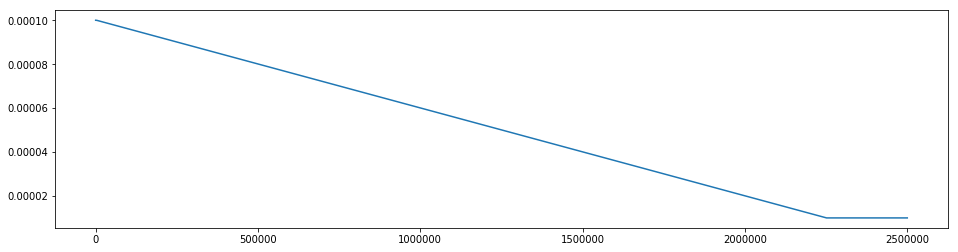

In [16]:

config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

global_init_op = tf.global_variables_initializer()
sess.run(global_init_op)

EPOCHS_BEFORE_SWA = 50
ALPHA1_LR = 0.0001
ALPHA2_LR = 0.00001

def get_learning_rate(step, epoch, steps_per_epoch):
    if epoch < EPOCHS_BEFORE_SWA:
        return ALPHA1_LR

    if step > int(0.9 * EPOCHS * steps_per_epoch):
        return ALPHA2_LR

    length_slope = int(0.9 * EPOCHS * steps_per_epoch) - EPOCHS_BEFORE_SWA * steps_per_epoch
    return ALPHA1_LR - ((ALPHA1_LR - ALPHA2_LR) / length_slope) * (step - EPOCHS_BEFORE_SWA * steps_per_epoch)

steps_per_epoch_train = EPOCHS// mb_size

all_steps = []
all_lr = []
print(EPOCHS)
print(mb_size)
print("steps_per_epoch_train : " , steps_per_epoch_train)
step = 0
for epoch in range(EPOCHS):
    for _ in range(steps_per_epoch_train):
        all_steps.append(step)
        all_lr.append(get_learning_rate(step, epoch, steps_per_epoch_train))
        step += 1 

plt.figure(figsize=(16,4))
plt.plot(all_steps, all_lr)
plt.show()
#EPOCHS , mb_size

In [17]:
from math import ceil

steps_per_epoch_train = int(ceil(EPOCHS/mb_size))
def fit_bn_statistics():
    sess.run(reset_bn_ops)
    
    feed_dict = {is_training_bn: True, use_moving_statistics: True}
    for _ in range(steps_per_epoch_train):
        sess.run(update_bn_ops, feed_dict=feed_dict)

def inference(with_moving_statistics=True):
    feed_dict = {is_training_bn: False,
                 use_moving_statistics: with_moving_statistics}
    g_loss = []
    d_loss = []
    nb_steps = 10
    
    for _ in range(nb_steps):
        _, Dloss = sess.run([D_solver, D_loss], feed_dict=feed_dict_train)
        _, Gloss = sess.run([G_solver, G_loss], feed_dict=feed_dict_train)
        g_loss.append(Gloss)
        d_loss.append(Dloss)
    
    return np.mean(g_loss), np.mean(d_loss)

feed_dict_train = {is_training_bn: True, 
                   use_moving_statistics:True,}

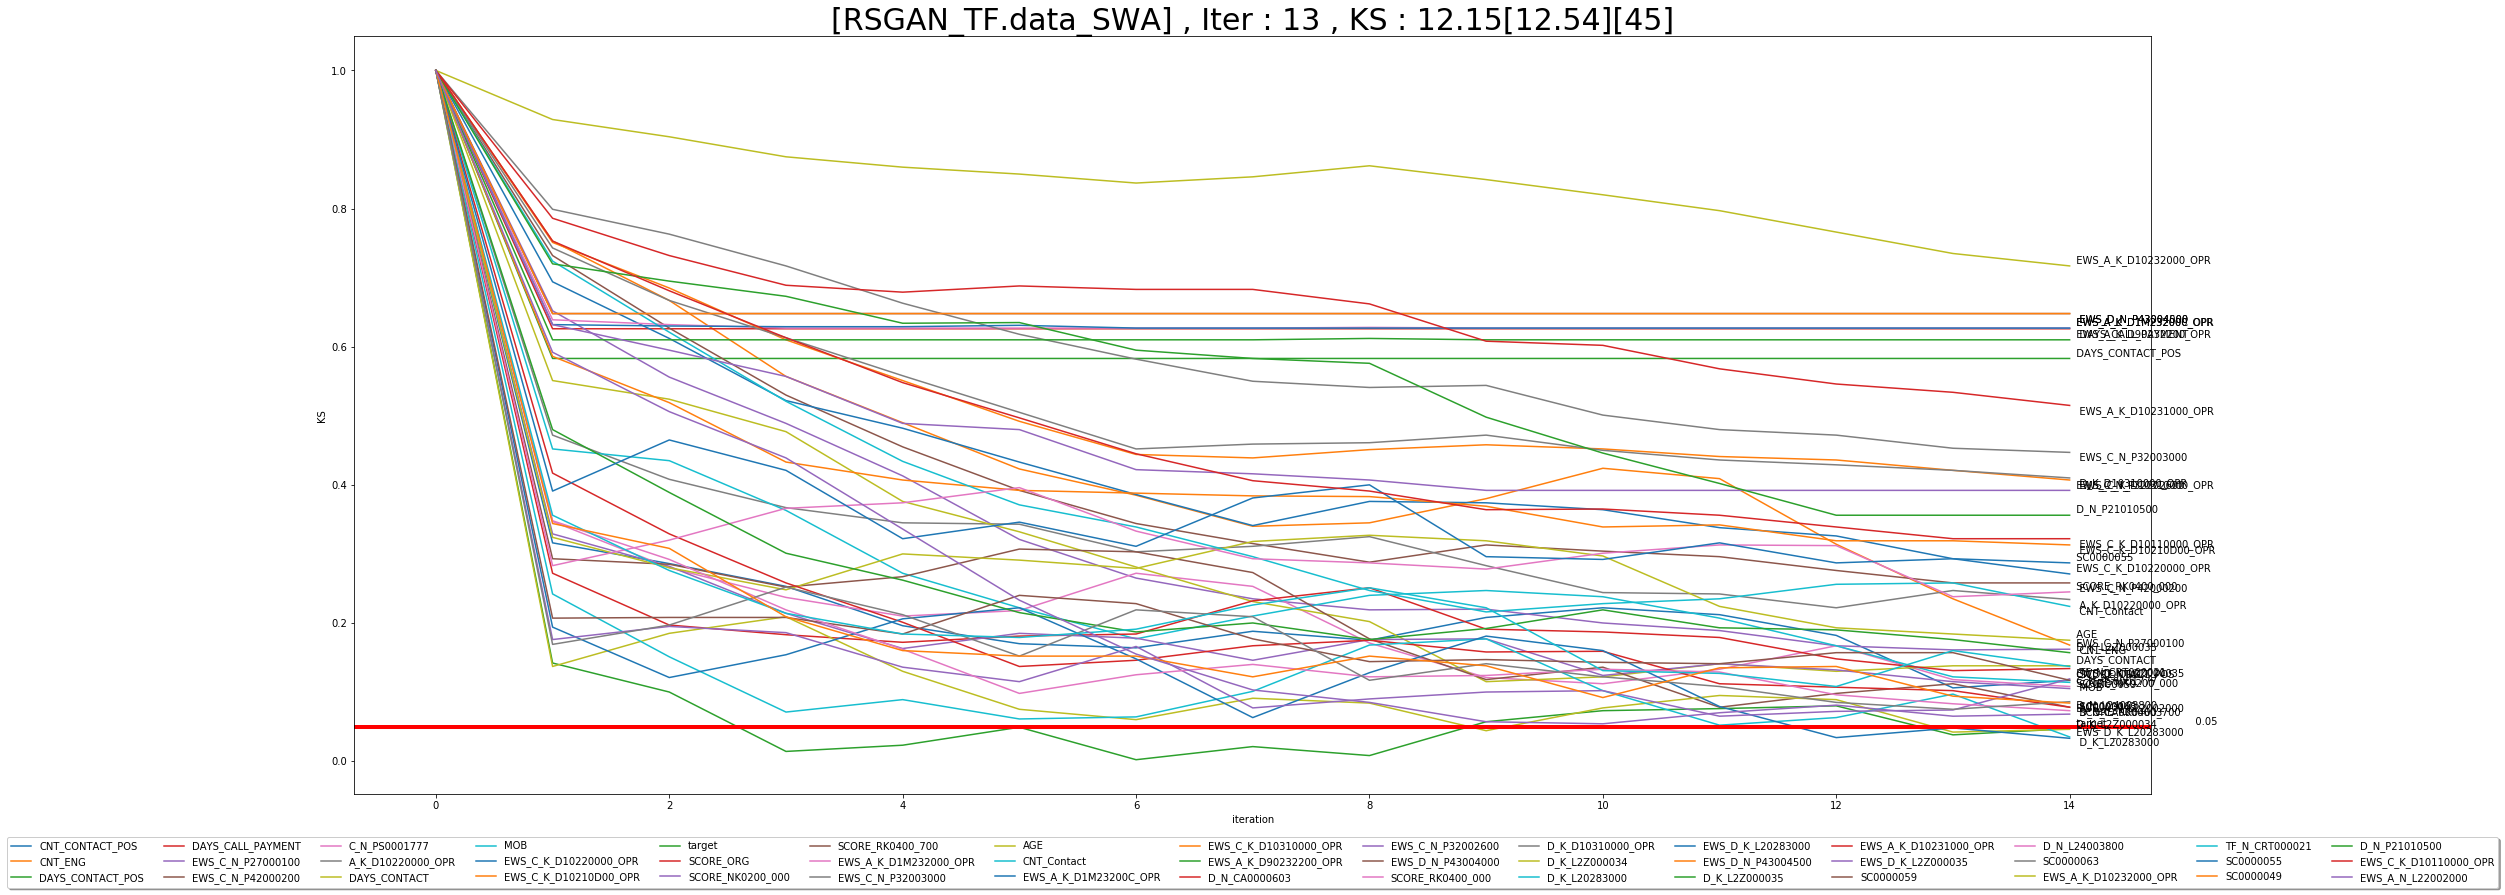

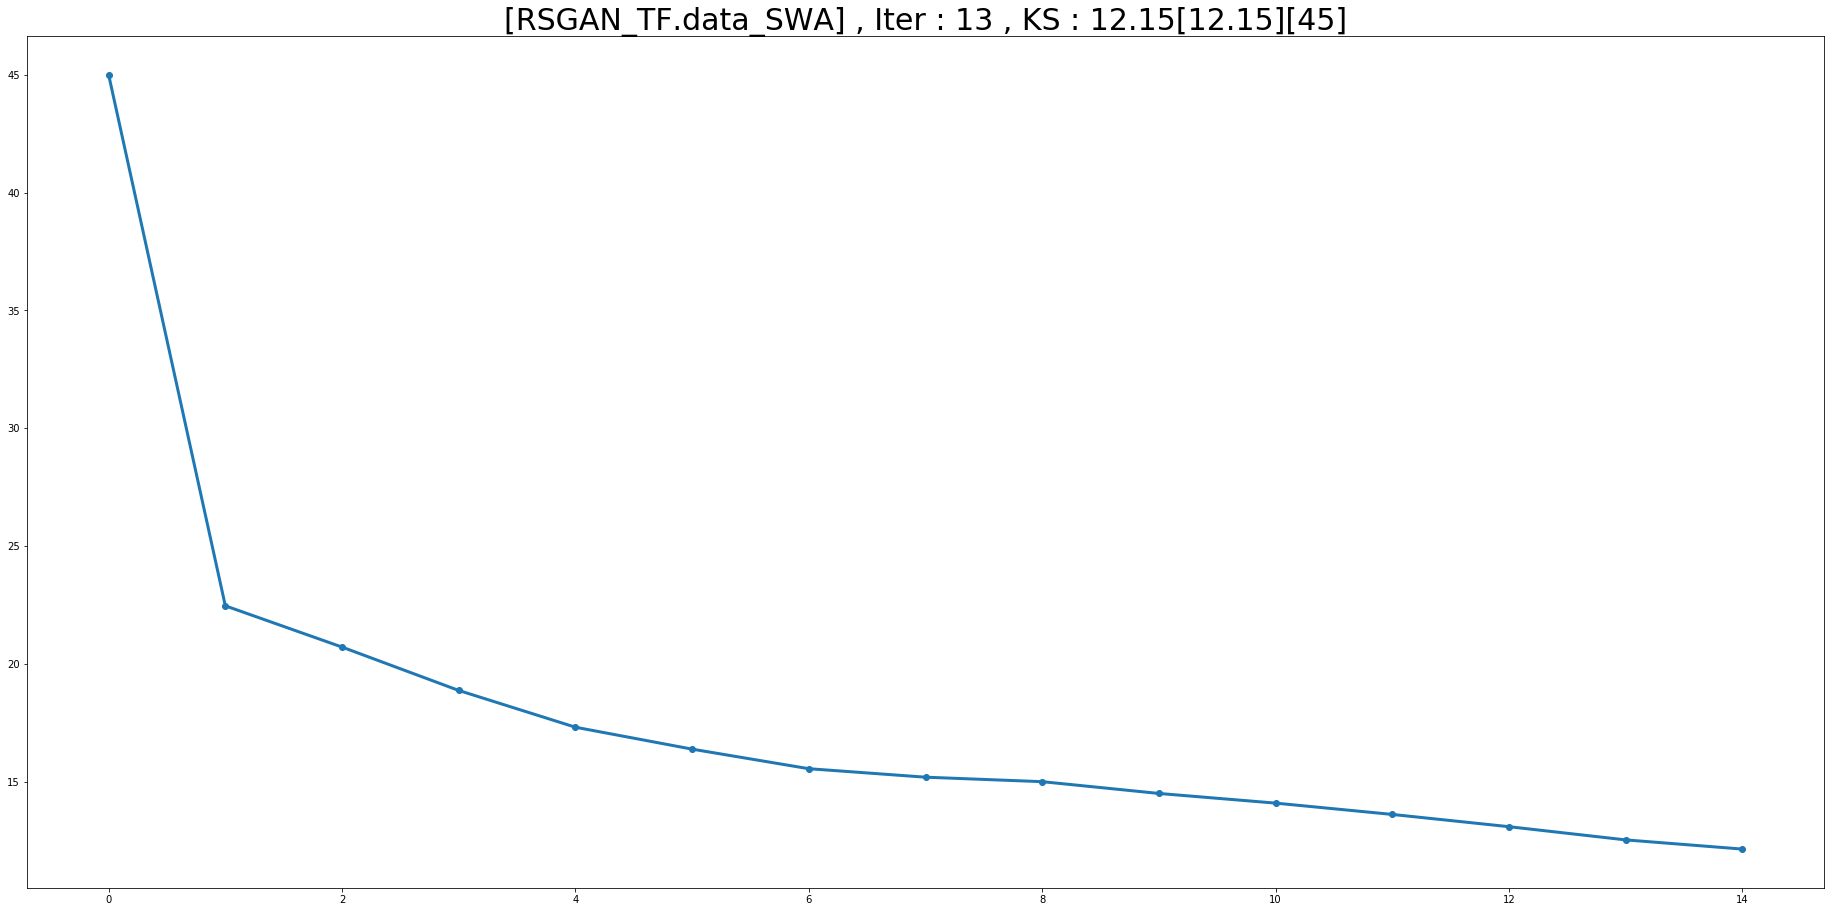

Iter: 13; D_loss: 1.799; G_loss: 1.079


In [ ]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')


config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()


ks_output = pd.DataFrame([[0]+[1.]*len(col)], columns = ["iter"]+col)

iteration , dloss ,  gloss = 0 , 0, 0
output = pd.DataFrame({"iter" : [iteration] , "dloss" : [dloss] , "gloss" : [gloss] })
ks_init = len(col)
Total_ks_graph = pd.DataFrame({"iter":[iteration] , "ks" :[ks_init]})
Margin = 8
ROW , COL = 7,7

step = 0

for i in range(EPOCHS) : 
    z_batch = sample_z(data_len , z_dim )
    sess.run(iter.initializer, feed_dict={ X : data , Z : z_batch  , batch_size: mb_size})
    iteration +=1
    for _ in range( batch_iter)  :
        feed_dict_train[learning_rate] = get_learning_rate(step, i , steps_per_epoch_train)
        dloss = []
        for _ in range(d_steps) :
            _, Dloss = sess.run([D_solver, D_loss], feed_dict=feed_dict_train)
            dloss.append(Dloss)
    
        _, gloss = sess.run([G_solver, G_loss], feed_dict=feed_dict_train)
        dloss = np.mean(dloss)
    
    
    sess.run(swa_op)
    sess.run(save_weight_backups)
    sess.run(swa_to_weights)
    sess.run(restore_weight_backups)
    
    fit_bn_statistics()
    dloss, gloss = inference(with_moving_statistics=False)
    
    output1 = pd.DataFrame({"iter" : [iteration] , "dloss" : [dloss] , "gloss" : [gloss] })
    output  = output.append(output1)
    dloss = round( np.float64(dloss),4)
    gloss = round( np.float64(gloss),4)
    ks_output , Total_ks_graph , Margin  , Total_KS = Check_KS(ks_output , Total_ks_graph , Margin , ROW , COL)
    print('Iter: {}; D_loss: {:.4}; G_loss: {:.4}'.format(i, dloss, gloss))
    
    if (i % 10 == 0) %  (Margin < 10) :
        clear_output(wait= True)
        show_plot(row = ROW , ncol= COL)




## Loss를 너무 강하게 제한을 주면 오히려 더 잘 안되는것 같기도하다.

### 일단 대기
## 새로 시도하는 것들 대부분이 안좋은 결과를...
> 새로운 사실!!!
>> 너무 강한 제약을 주면 학습이 더 안된다.!!

## 실시간 KS 그림을 찍으면서 기준 KS를 통과하면 저장하는 방식으로 진행

In [ ]:
## 데이터 다시 생성 파트 
chkpt_fname = tf.train.latest_checkpoint("./")
saver.restore(sess, chkpt_fname)
z_test_value = sample_z(m=5000 , n=z_dim)
good_replay_v = sess.run(G_sample, feed_dict={z : z_test_value})